<h1>Observations</h1>
<p>1. For the last 100 tweets as of 4/2/2018, CBS was the most positive, followed by BBC. CNN, Fox and the NY Times were basically neutral, with CNN and Fox having a slightly negative tilt.</p>
<p>2. Despite having an overall compound score that was neutral, the NY Times had the highest standard deviation when compared to the other organizations. This says to me that they have roughly the same number of positive tweets as negative ones.</p>
<p>3. CBS was the only organization with a non-zero median.  In this case the median for CBS was positive, which indicates that their compound scores aren't because of a few strongly positive tweets.</p>

It would be interesting to see how these scores changed during a negative event such as a recession or during a positive event like the Olympics.

In [1]:
# Dependencies
import tweepy
import numpy as np
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
from matplotlib import style
style.use('ggplot')

# Import and Initialize Sentiment Analyzer
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
analyzer = SentimentIntensityAnalyzer()

# Twitter API Keys
from config import (twitter_consumer_key, twitter_consumer_secret, twitter_access_token, twitter_access_token_secret)

# Setup Tweepy API Authentication
auth = tweepy.OAuthHandler(twitter_consumer_key, twitter_consumer_secret)
auth.set_access_token(twitter_access_token, twitter_access_token_secret)
api = tweepy.API(auth, parser=tweepy.parsers.JSONParser())

# Increase the size of the scatter plots
plt.rcParams["figure.figsize"] = [10,8]

In [2]:
# Target User Accounts
target_user = ("@BBC", "@CBS", "@CNN", "@FoxNews", "@NYTimes")

# Spelled out names of twitter accounts
target_names = ('BBC','CBS','CNN','Fox','NYT')

# List for dictionaries of results
results_list = []

# Variables for holding sentiments
sentiments = []

# Loop through each user
for user in target_user:

    # Variables for holding sentiments
    compound_list = []
    positive_list = []
    negative_list = []
    neutral_list = []

    # Counter
    counter = 1

    # Variable for max_id
    oldest_tweet = None

    # Loop through 5 pages of tweets (total 100 tweets)
    for x in range(5):

        # Get all tweets from home feed
        public_tweets = api.user_timeline(user, max_id = oldest_tweet)

        # Loop through all tweets 
        for tweet in public_tweets:

            # Run Vader Analysis on each tweet
            results = analyzer.polarity_scores(tweet["text"])
            compound = results["compound"]
            pos = results["pos"]
            neu = results["neu"]
            neg = results["neg"]
            tweets_ago = counter

            # Get Tweet ID, subtract 1, and assign to oldest_tweet
            oldest_tweet = tweet['id'] - 1

            # Add sentiments for each tweet into a list
            sentiments.append({"Username": user,
                               "Date": tweet["created_at"], 
                               "Tweet": tweet["text"],
                               "Compound": compound,
                               "Positive": pos,
                               "Negative": neg,
                               "Neutral": neu,
                               "Tweets Ago": counter})

            # Add to counter 
            counter += 1

In [3]:
# Convert sentiments to a dataframe
sentiments_pd = pd.DataFrame.from_dict(sentiments).set_index("Username")

# Export the dataframe to CSV
sentiments_pd.to_csv("Sentiment Analysis of Media Tweets.csv")

# Print out the dataframe to view results
sentiments_pd.head()

,Compound,Date,Negative,Neutral,Positive,Tweet,Tweets Ago
Username,,,,,,,
@BBC,-0.5574,Mon Apr 02 14:14:17 +0000 2018,0.184,0.816,0.000,RT @BBCBreaking: South African anti-apartheid ...,1
@BBC,0.4215,Mon Apr 02 13:32:07 +0000 2018,0.000,0.859,0.141,Is it easier to be a businesswoman in the West...,2
@BBC,0.0000,Mon Apr 02 11:58:06 +0000 2018,0.000,1.000,0.000,RT @BBCWorld: Hill Street Blues creator Steven...,3
@BBC,0.2235,Mon Apr 02 11:07:00 +0000 2018,0.000,0.894,0.106,"""I have cerebral palsy. But that won't stop me...",4
@BBC,0.0000,Mon Apr 02 10:02:06 +0000 2018,0.000,1.000,0.000,From Easter egg nest cakes to hot cross buns: ...,5


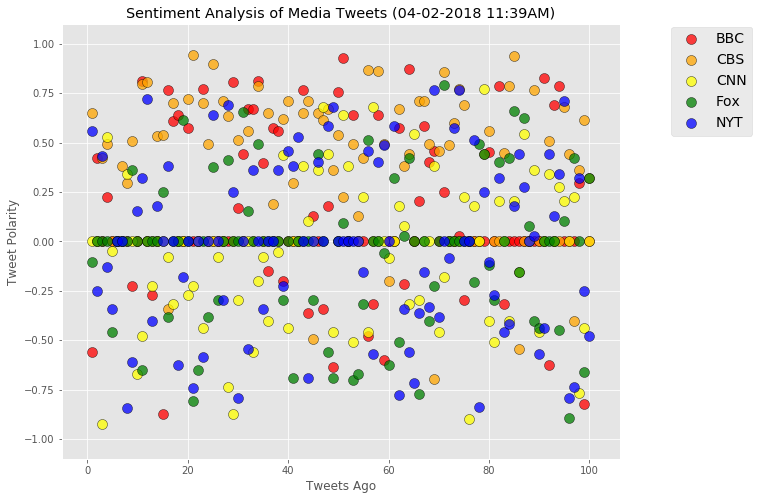

In [4]:
# This section creates the scatterplot of sentiments of the last 100 tweets sent out by each news organization

# Clear plot, just in case
plt.clf()

# Set list of colors
colors = ['red', 'orange', 'yellow', 'green', 'blue']

# Loop through each twitter account
for index, user in enumerate(target_user):
    
    # Create scatterplot for each twitter account
    plt.scatter(sentiments_pd[sentiments_pd.index==user]["Tweets Ago"], 
                sentiments_pd[sentiments_pd.index==user]["Compound"],
                marker="o", facecolors=colors[index], edgecolors="black", s=100, alpha=0.75)

# Adjust other graph properties
now = datetime.now()
now = now.strftime("%m-%d-%Y %H:%M%p")
plt.title(f"Sentiment Analysis of Media Tweets ({now})")
plt.legend(target_names, loc='best', bbox_to_anchor=(1.25, 1.01), prop={'size': 14})
plt.ylim(-1.1, 1.1)
plt.ylabel("Tweet Polarity")
plt.xlabel("Tweets Ago")
plt.show()

# Save the chart
plt.savefig("Sentiment Analysis of Media Tweets.png")

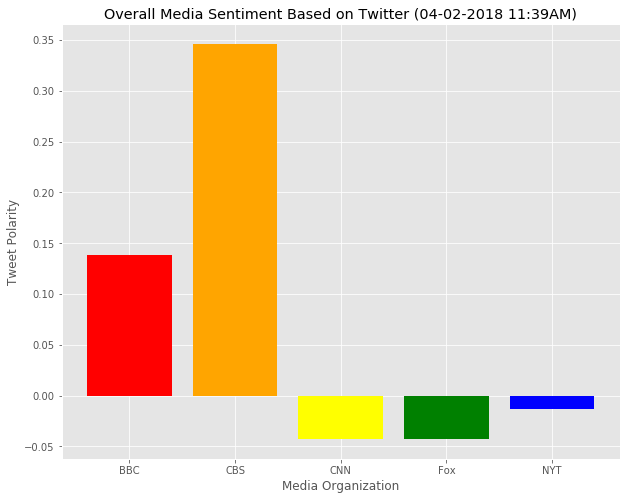

In [5]:
# This section creates the bar graph showing the overall sentiments of the last 100 tweets from each organization

# Clear plot, just in case
plt.clf()

# List for holding overall sentiment
overall_sentiment_list = []

# Create values for x-axis
x_axis = np.arange(len(target_user))

# Loop through each twitter account
for user in target_user:
    
    # Append average compound score to list
    overall_sentiment_list.append(sentiments_pd[sentiments_pd.index==user]["Compound"].mean())

# Create bar chart
plt.bar(x_axis, overall_sentiment_list, color=colors, align="edge")
    
# Adjust other graph properties
plt.title(f"Overall Media Sentiment Based on Twitter ({now})")
tick_locations = [value+0.4 for value in x_axis]
plt.xticks(tick_locations, target_names)
plt.xlabel("Media Organization")
plt.ylabel("Tweet Polarity")
plt.show()

# Save the chart
plt.savefig("Overall Media Sentiment.png")

In [6]:
# This section compares general statistics for the compound score for each organization

# Variable for holding compound scores
compound_list = []

# Loop through each user
for user in target_user:
    
    # Append average compound score to list
    compound_list.append({"Username": user,
                          "Mean": sentiments_pd[sentiments_pd.index==user]["Compound"].mean(),
                          "Median": sentiments_pd[sentiments_pd.index==user]["Compound"].median(),
                          "Min": sentiments_pd[sentiments_pd.index==user]["Compound"].min(),
                          "Max": sentiments_pd[sentiments_pd.index==user]["Compound"].max(),
                          "Std Dev": np.std(sentiments_pd[sentiments_pd.index==user]["Compound"])
                        })
    
# Convert list to a dataframe
compound_df = pd.DataFrame.from_dict(compound_list).set_index("Username").round(3)

# Print out the dataframe to view results
compound_df

,Max,Mean,Median,Min,Std Dev
Username,,,,,
@BBC,0.930,0.139,0.00,-0.875,0.398
@CBS,0.945,0.347,0.44,-0.698,0.364
@CNN,0.772,-0.043,0.00,-0.922,0.346
@FoxNews,0.791,-0.043,0.00,-0.896,0.356
@NYTimes,0.765,-0.013,0.00,-0.844,0.425
